## 11.1 교차검증 모델 만들기
실전에서 모델이 얼마나 잘 작동할지 평가하고 싶습니다.

데이터 전처리 파이프라인을 만들고 모델을 훈련한 다음 교차검증으로 평가합니다.

In [4]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 숫자 데이터셋을 로드합니다.
digits = datasets.load_digits()

# 특성 행렬을 만듭니다.
features = digits.data

# 타깃 벡터를 만듭니다.
target = digits.target

# 표준화 객체를 만듭니다.
standardizer = StandardScaler()

# 로지스틱 회귀 객체를 만듭니다.
logit = LogisticRegression()

# 표준화한 다음 로지스틱 회귀를 실행하는 파이프라인을 만듭니다.
pipeline = make_pipeline(standardizer, logit)

# k-폴드 교차검증을 만듭니다.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# k-폴드 교차검증을 수행합니다.
cv_results = cross_val_score(pipeline, # 파이프라인
                             features, # 특성행렬
                             target, # 타깃 벡터
                             cv=kf, # 교차검증 기법
                             scoring="accuracy", # 평가 지표
                             n_jobs=-1) # 모든 CPU 코어 사용

# 평균을 계산합니다.
cv_results.mean()

0.9693916821849783

k-폴드 교차검증(k-fold cross-validation, KFCV)에서는 데이터를 fold라고 부르는 $k$개의 부분으로 나눕니다.$k$-1개 폴드를 하나의 훈련 세트로 합쳐 모델을 훈련하고 남은 폴드를 테스트 세트처럼 사용합니다. 이를 $k$번 반복합니다. 반복마다 다른 폴드를 테스트 세트로 사용합니다. $k$번 반복에서 얻은 모델 성능을 평균하여 최종 성능을 산출합니다.

해결에서 10개의 폴드를 사용하여 $k$-폴드 교차검증을 수행했습니다. 평가 정수는 cv_results에 저장되어 있습니다.

In [5]:
# 10개 폴드의 점수를 모두 확인하기
cv_results

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98333333, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

KFCV를 사용할 때 고려해야 할 중요한 점이 세 가지 있습니다. 첫째, KFCV는 각 샘플이 다른 샘플과 독립적으로 생성되었다고 가정합니다(즉 데이터는 independent identically distributed, iid입니다). 데이터가 iid라면 폴드를 나누기 전에 샘플을 섞는 것이 좋은 생각입니다. 사이킷런에서는 shuffle=True로 지정하여 섞을 수 있습니다.

둘째, KFCV를 사용하여 classifier를 평가할 때, 각 타깃 클래스의 샘플이 거의 같은 비율로 폴드에 담기는 것이 좋습니다(계층별 $k$-폴드, stratified k-fold라고 부릅니다). 예를 들어 성별 타깃 벡터 중에서 80% 샘플이 남성이라면 각 폴드도 80% 남성과 20% 여성 샘플로 이루어져야 합니다. 사이킷런에서는 KFold 클래스를 StratifiedKFold로 바꾸어 계층별 $k$-폴드 교차검증을 수행할 수 있습니다.

마지막으로 검증 세트나 교차검증을 사용할 때 훈련 세트에서 데이터를 전처리하고 이 변환을 훈련 세트와 테스트 세트에 모두 적용하는 것이 중요합니다. 예를 들면 표준화 객체 standardizer의 fit 메서드를 호출하여 훈련 세트의 평균과 분산을 계산합니다. 그다음 이 변환을 (transform 메서드를 사용해) 훈련 세트와 테스트 세트에 모두 적용합니다.

In [7]:
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=1)

# 훈련 세트로 standardizer의 fit 메서드를 호출합니다.
standardizer.fit(features_train)

# 훈련 세트와 테스트 세트에 모두 적용합니다.
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test)

이렇게 하는 이유는 테스트 세트를 모르는 척하기 위해서입니다. 이 전처리 객체를 훈련 세트와 테스트 세트에 있는 모든 샘플로 훈련한다면 테스트 세트의 정보가 훈련 세트로 유출된 것입니다. 이 규칙은 특성 선택 같은 모든 전처리 단계에 적용됩니다.

사이킷런의 pipeline 패키지는 교차검증 기법을 사용할 때 이 규칙을 손쉽게 구현할 수 있도록 도와줍니다. 먼저 데이터를 전처리 (예를 들면 standardizer)하고 모델(로지스틱 회귀인 logit)을 훈련하는 파이프라인을 만듭니다.

In [8]:
# 파이프라인을 만듭니다.
pipeline = make_pipeline(standardizer, logit)

그다음 이 파이프라인으로 KFCV를 실행하면 사이킷런이 모든 작업을 알아서 처리합니다.

In [9]:
# k-폴드 교차검증 수행
cv_results = cross_val_score(pipeline, # 파이프라인
                             features, # 특성행렬
                             target, # 타깃 벡터
                             cv=kf, # 교차검증 기법
                             scoring="accuracy", # 평가 지표
                             n_jobs=-1) # 모든 CPU 코어 사용

cross_val_score에는 아직 이야기하지 않은 중요한 세 개의 매개변수가 있습니다. cv는 교차검증 기법을 결정합니다. $k$-폴드를 가장 많이 사용하지만 다른 방식도 있습니다. LOOCV(leave-one-out-cross-validation)는 폴드의 수 $k$가 샘플의 개수와 같습니다. scoring 매개변수는 이 장의 다른 여러 레시피에서 설명할 모델 성공의 측정 방법을 결정합니다. 마지막으로 n_jobs=-1은 사이킷런에게 가용한 모든 코어를 사용하도록 지시합니다. 예를 들어 사용하는 컴퓨터에 (요즘 노트북의 기본 사양인) 네 개의 코어가 있다면 사이킷런은 네 개의 코어를 모두 동시에 사용해 작업의 속도를 높입니다.

LOOCV는 LeaveOneOut 클래스에 구현되어 있습니다. LeaveOneOut 클래스는 KFold(n_splits=n)과 동일합니다(n은 샘플 개수).

KFold와 StratifiedKFold의 n_splits 매개변수 기본값은 5입니다.

ShuffleSplit는 반복 횟수에 상관없이 훈련 폴드와 테스트 폴드 크기를 임의로 지정할 수 있습니다. train_size, test_size 매개변수에는 사용할 샘플 개수 또는 비율을 입력합니다. 반복마다 랜덤하게 분할하기 때문에 하나의 샘플이 여러 번 테스트 폴드에 포함될 수 있습니다. 계층별 교차검증을 위한 StratifiedShuffleSplit도 있습니다. 다음 코드는 훈련 폴드로 50%, 테스트 폴드로 20%를 사용하여 10번 반복하는 예입니다.

In [10]:
from sklearn.model_selection import ShuffleSplit

# ShuffleSplit 분할기를 만듭니다.
ss = ShuffleSplit(n_splits=10, train_size=0.5, test_size=0.2, random_state=42)

# 교차검증을 수행합니다.
cv_results = cross_val_score(pipeline,
                             features,
                             target,
                             cv=ss,
                             scoring="accuracy",
                             n_jobs=-1)

# 평균을 계산합니다.
cv_results.mean()

0.9630555555555554

사이킷런 0.19 버전에서는 교차검증을 반복하여 실행할 수 있는 RepeatedKFold와 StratifiedRepeatedKFold가 추가되었습니다. 다음 코드는 10-폴드 교차검증을 5번 반복하는 RepeatedKFold의 예입니다.

In [11]:
from sklearn.model_selection import RepeatedKFold

# RepeatedKFold 분할기를 만듭니다.
rfk = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# 교차검증을 수행합니다.
cv_results = cross_val_score(pipeline,
                             features,
                             target,
                             cv=rfk,
                             scoring="accuracy",
                             n_jobs=-1)

# 검증 점수 개수를 확인합니다.
len(cv_results)

50

총 50개의 교차검증 점수가 생성되었습니다. n_splits 매개변수 기본값은 5이고 n_repeats 매개변수 기본값은 10입니다.

## 11.2 기본 회귀 모델 만들기
다른 모델과 비교하기 위해 간단한 기본 회귀 모델을 만들고 싶습니다.

사이킷런의 DummyRegressor를 사용하여 기본 모델로 사용할 간단한 dummy 모델을 만듭니다.

In [6]:
# from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
boston = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
features = np.hstack([boston.values[::2, :], boston.values[1::2, :2]])
target = boston.values[1::2, 2]

# 데이터를 로드합니다.
# boston = load_boston()

# 특성을 만듭니다.
# features, target = boston.data, boston.target

# 훈련 세트와 테스트 세트를 나눕니다.
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

# 더미 회귀 모델을 만듭니다.
dummy = DummyRegressor(strategy='mean')

# 더미 회귀 모델을 훈련합니다.
dummy.fit(features_train, target_train)

# R^2 점수를 계산합니다.
dummy.score(features_test, target_test)

-0.001119359203955339

다른 모델을 훈련하고 평가하여 성능 점수를 비교합니다.

In [8]:
from sklearn.linear_model import LinearRegression

# 간단한 선형 회귀 모델을 훈련합니다.
ols = LinearRegression()
ols.fit(features_train, target_train)

# R^2 점수를 계산합니다.
ols.score(features_test, target_test)

0.635463843320215

DummyRegressor 클래스는 실제 모델과 비교하기 위해 사용할 수 있는 매우 간단한 모델을 만듭니다. 기존 제품이나 시스템의 단순한 예측 방식을 흉내 내는 데 종종 사용합니다. 예를 들면 모든 새로운 사용자는 특성에 상관없이 첫 달에 100달러를 사용할 것이라고 가정하도록 애초부터 시스템에 하드코딩되어 있을지 모릅니다. 이런 가정을 기본 모델로 삼으면 머신러닝 방식을 사용했을 때 장점을 명확히 확인할 수 있습니다.

DummyRegressor 클래스는 strategy 매개변수를 사용하여 예측 방법을 지정합니다. 훈련 세트의 평균 또는 중간값을 사용할 수 있습니다. 또한 strategy를 constant로 지정하고 constant 매개변수를 사용하면 모든 샘플에 대해 일정한 값으로 예측하는 더미 회귀 모델을 만들 수 있습니다.

In [9]:
# 모든 샘플에 대해 20으로 예측하는 더미 회귀 모델을 만듭니다.
clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)

# 점수를 계산합니다.
clf.score(features_test, target_test)

-0.06510502029325727

score 메서드에 대해 언급할 것이 하나 있습니다. 기본적으로 score 메서드는 결정계수($R^2$)값을 반환합니다. $$R^2 = 1-\frac{\sum_{i}(y_i -\hat{y_i})^2}{\sum_i(y_i-\bar{y})^2}$$
여기에서 $y_i$는 샘플의 정답 타깃값입니다. $\hat{y_i}$은 예측한 값이고 $\bar{y}$은 타깃 벡터의 평균값입니다. $R^2$이 1에 가까울수록 특성이 타깃 벡터의 분산을 잘 설명합니다.

strategy가 mean일 때 평균값으로 예측하고 median일 때 중간값으로 예측합니다. strategy='quantile'로 지정하면 quantile 매개변수에 지정한 분위값을 예측으로 사용합니다. quantile 매개변수에는 0과 1 사이의 실숫값을 지정하며 0.5일 때 중간값과 같고 0이면 최솟값, 1이면 최댓값입니다. 다음 코드는 훈련 세트의 타깃값의 최댓값으로 예측을 만드는 DummyRegressor의 예입니다.

In [11]:
clf = DummyRegressor(strategy='quantile', quantile=1.0)
clf.fit(features_train, target_train)

# 훈련 세트 타깃의 최댓값으로 예측합니다.
clf.predict(features_test)

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [12]:
import numpy as np
# 훈련 세트의 타깃에서 최댓값을 확인합니다.
np.max(target_train)

50.0

## 11.3 기본 분류 모델 만들기
다른 모델과 비교하기 위해 간단한 기본 회귀 모델을 만들고 싶습니다.

사이킷런의 DummyClassifier를 사용합니다.

In [16]:
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()

features, target = iris.data, iris.target

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

dummy = DummyClassifier(strategy='uniform', random_state=1)

dummy.fit(features_train, target_train)

dummy.score(features_test, target_test)

0.42105263157894735

훈련된 다른 모델과 기본 모델을 비교하여 더 나은지 확인할 수 있습니다.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# 분류 모델을 만듭니다.
classifier = RandomForestClassifier()

# 모델을 훈련합니다.
classifier.fit(features_train, target_train)

# 정확도 점수를 계산합니다.
classifier.score(features_test, target_test)

0.9736842105263158

분류 모델의 성능을 측정하는 일반적인 방법은 랜덤한 추측보다 얼마나 더 나은지 비교하는 것입니다. 사이킷런의 DummyClassifier를 사용하면 이런 비교를 쉽게할 수 있습니다. strategy 매개변수는 예측값을 생성하는 여러 가지 옵션을 제공합니다. 전형적으로 많이 사용하는 두 가지 전략이 있습니다. 첫 번째, stratified 옵션은 훈련 세트에 있는 타깃 벡터의 클래스 비율에 비례하는 예측을 만듭니다(즉 훈련 세트에서 샘플의 20%가 여성이라면 DummyClassifier는 20%를 여성으로 예측합니다). 두 번째, uniform 옵션은 클래스 비중이 균등하도록 랜덤하게 예측합니다. 예를 들어 샘플의 20%가 여성이고 80%가 남성일 때 uniform 옵션은 50%는 여성, 50%는 남성으로 예측합니다.

strategy에서 자주 사용하는 또 다른 옵션은 most_frequent입니다. 이 옵션은 무조건 훈련 세트에서 가장 많은 타깃 레이블로 예측을 만듭니다. 다음 코드는 most_frequent 옵션을 사용하는 예입니다.

In [18]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)

# 훈련 세트 타깃에서 가장 많은 값으로 예측합니다.
dummy.predict(features_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

훈련 세트에 있는 타깃값을 확인해보면 클래스 레이블 2가 가장 많습니다.

In [19]:
# 훈련 세트의 타깃 개수를 확인합니다.
np.bincount(target_train)

array([37, 34, 41], dtype=int64)

## 11.4 이진 분류기의 예측 평가하기
훈련된 분류 모델의 품질을 평가하고 싶습니다.

사이킷런의 cross_val_score 함수를 사용하여 교차검증을 수행할 때 scoring 매개변수에 성능 지표 중 하나를 선택할 수 있습니다. 예를 들어, 정확도, 정밀도, 재현율, $F_1$이 있습니다.

정확도는 널리 사용되는 성능 지표입니다. 단순히 올바르게 예측된 샘플의 비율입니다.
$$정확도 = \frac{TP+TN}{TP+TN+FP+FN}$$

scoring="accuracy"로 지정하여 (기본값인) 5-폴드 교차검증의 정확도를 측정할 수 있습니다.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 2,
                           random_state = 1)

# 로지스틱 회귀 모델을 만듭니다.
logit = LogisticRegression()

# 정확도를 사용하여 교차검증을 수행합니다.
cross_val_score(logit, X, y, scoring='accuracy')

array([0.9555, 0.95  , 0.9585, 0.9555, 0.956 ])

정확도는 직관적이고 쉽게 설명할 수 있다는 것이 장점입니다. 정확도는 단순히 정확히 예측한 샘플의 비율입니다. 그러나 실전에서는 클래스 비율이 불균형한 데이터가 많습니다. 클래스가 불균형하면 모델의 정확도는 높지만 예측 성능이 나쁜 역설적인 상황이 발생합니다. 

정밀도는 양성으로 예측한 샘플 중에서 진짜 양성 클래스의 비율입니다. 이를 예측에 포함된 잡음이라고 생각할 수 있습니다. 즉 어떤 것을 양성 클래스로 예측했을 때 얼마나 올바른지를 나타냅니다. 높은 정밀도의 모델은 양성 클래스라고 확신이 높을 때만 양성 샘플로 예측합니다. 정밀도 공식은 다음과 같습니다.
$$precision = \frac{TP}{TP+FP}$$

In [4]:
# 정밀도를 사용한 교차검증
cross_val_score(logit, X, y, scoring='precision')

array([0.95963673, 0.94820717, 0.9635996 , 0.96149949, 0.96060606])

재현율은 진짜 양성 샘플 중에서 양성으로 예측한 비율입니다. 재현율은 모델이 양성 클래스 샘플을 구분하는 능력을 측정합니다. 높은 재현율의 모델은 샘플을 양성 클래스로 예측하기 위해서 낮은 기준을 가집니다.
$$recall = \frac{TP}{TP+FN}$$

In [5]:
# 재현율을 사용한 교차검증
cross_val_score(logit, X, y, scoring='recall')

array([0.951, 0.952, 0.953, 0.949, 0.951])

거의 항상 정밀도와 재현율 간의 균형을 맞추어야 합니다. 이를 위해 $F_1$ 점수가 만들어졌습니다. $F_1$은 정밀도와 재현율의 조화 평균입니다.
$$F_1 = 2 \times \frac{precision \times recall}{precision + recall}$$
이는 진짜 양성 레이블을 가진 샘플을 양성으로 성공적으로 예측한 정도를 측정합니다.

In [6]:
# f1 점수를 사용한 교차검증
cross_val_score(logit, X, y, scoring='f1')

array([0.95529884, 0.9500998 , 0.95827049, 0.95520886, 0.95577889])

평가 지표로서 정확도는 유용한 성질을 가지고 있습니다. 특히 이해하기 쉽습니다. 하지만 종종 정밀도와 재현율의 균형을 맞추는 것이 더 좋은 지표가 됩니다. 즉 비관적인 모델과 긍정적인 모델 사이의 트레이드오프입니다. $F_1$은 정밀도와 재현율을 비교적 동등하게 취급하여 이 둘 사이의 균형을 표현합니다.

cross_val_score를 사용하는 대신 진짜 y값과 예측한 y값이 있으면 직접 정확도와 재현율을 계산할 수 있습니다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# 테스트 세트의 예측을 만듭니다.
y_hat = logit.fit(X_train, y_train).predict(X_test)

# 정확도를 계산합니다.
accuracy_score(y_test, y_hat)

0.947

cross_val_score 함수의 cv 매개변수를 지정하지 않으면 회귀일 때는 KFold, 분류일 때는 StratifiedKFold 분할기가 사용됩니다. cv 매개변수에 정수를 입력하여 기본 분할기의 폴드 수를 지정할 수도 있습니다.

사이킷런 0.19 버전에서 cross_validate 함수가 추가되었습니다. 이 함수는 cross_val_score와 사용법이 매우 비슷하지만 scoring 매개변수에 여러 개의 평가 지표를 추가할 수 있습니다.

In [9]:
from sklearn.model_selection import cross_validate

# 정확도와 정밀도를 사용한 교차검증
cross_validate(logit, X, y, scoring=["accuracy", "precision"])

{'fit_time': array([0.03770471, 0.02892303, 0.02692604, 0.02495122, 0.01692486]),
 'score_time': array([0.014961  , 0.01097012, 0.01097035, 0.00599527, 0.00817347]),
 'test_accuracy': array([0.9555, 0.95  , 0.9585, 0.9555, 0.956 ]),
 'test_precision': array([0.95963673, 0.94820717, 0.9635996 , 0.96149949, 0.96060606])}

accuracy와 precision 두 개의 평가 지표에 대해 각각 다섯 개의 교차검증 점수가 반환되었습니다. 

## 11.5 이진 분류기 임곗값 평가하기
이진 분류기를 여러 가지 확률 임곗값으로 평가하고 싶습니다.

ROC(receiving operating charcteristic) 곳너은 이진 분류기의 품질을 평가하는 데 널리 사용하는 방법입니다. ROC는 확률 임곗값(즉 어떤 샘플을 한 클래스로 예측할 확률)마다 진짜 양성과 거짓 양성 개수를 비교합니다. ROC 곡선을 그리면 모델의 성능을 확인할 수 있습니다. 모든 샘플을 올바르게 예측하는 분류기는 바로 수직으로 꼭대기까지 올라갑니다. 랜덤하게 예측하는 분류기는 대각선으로 나타납니다. 좋은 모델일수록 실선에 가깝습니다. 사이킷런에서는 roc_curve 함수를 사용하여 임곗값마다 진짜 양성과 거짓 양성을 계산하여 그래프를 그릴 수 있습니다.

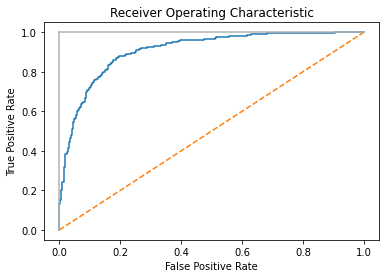

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

features, target = make_classification(n_samples=10000,
                                       n_features=10,
                                       n_classes=2,
                                       n_informative=3,
                                       random_state=3)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=1)

logit = LogisticRegression()

logit.fit(features_train, target_train)

# 예측 확률을 계산하기
target_probabilities = logit.predict_proba(features_test)[:,1]

# 진짜 양성 비율과 거짓 양성 비율을 계산합니다.
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)

# ROC 곡선을 그립니다.
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

지금까지는 예측값을 기반으로 모델을 평가했습니다. 하지만 많은 머신러닝 알고리즘들은 확률을 기반으로 예측값을 만듭니다. 즉, 모든 샘플은 각 클래스에 속할 명시적인 확률이 주어집니다. predict_proba 메서드를 사용하여 해결에 있는 첫 번째 샘플에 대한 예측 확률을 확인할 수 있습니다.

In [4]:
# 예측 확률을 계산합니다.
logit.predict_proba(features_test)[0:1]

array([[0.86891533, 0.13108467]])

classes_를 사용하여 클래스를 확인할 수 있습니다.

In [5]:
logit.classes_

array([0, 1])

이 예에서 첫 번째 샘플은 음성 클래스(0)가 될 가능성이 87% 정도이고 양성 클래스(1)가 될 가능성은 13%입니다. 기본적으로 사이킷런은 확률이 0.5(임곗값)보다 크면 양성 클래스로 예측합니다. 종종 실제 필요에 의해 중간값보다 다른 임곗값을 사용해 모델을 편향되게 만들어야 할 때가 있습니다. 예를 들면 거짓 양성이 회사에 매우 큰 비용을 치르게 한다면 확률 임곗값이 높은 모델을 선호합니다. 일부 양성 샘플을 예측하지 못할 수 있지만 양성으로 예측된 샘플은 이 예측이 맞을 것이라고 강하게 확신할 수 있습니다. 이는 진짜 양성 비율(TPR)과 거짓 양성 비율(FPR) 사이의 trade-off입니다. 진짜 양성 비율은 올바르게 예측된 양성 샘플 개수를 전체 진짜 양성 샘플의 수로 나눈 것입니다.
$$진짜 양성 비율(TPR)=\frac{진짜 양성}{진짜 양성+거짓 음성}$$

거짓 양성 비율은 잘못 예측된 양성 클래스 개수를 모든 진짜 음성 클래스 샘플 수로 나눈 것입니다.

$$거짓 양성 비율(FPR)=\frac{거짓 양성}{거짓 양성+진짜 음성}$$

ROC 곡선은 확률 임곗값마다 TPR과 FPR을 나타냅니다. 예를 들어 해결에서 임곗값이 0.5일 때 TPR은 0.81이고 FPR은 0.15입니다.

In [9]:
print("임곗값:", threshold[116])
print("진짜 양성 비율:", true_positive_rate[116])
print("거짓 양성 비율:", false_positive_rate[116])

임곗값: 0.5331715230155317
진짜 양성 비율: 0.810204081632653
거짓 양성 비율: 0.14901960784313725


임곗값을 80%로 증가시키면(즉 샘플을 양성으로 예측하기 위해 모델이 확신하는 정도를 증가시키면) TPR과 FPR이 크게 감소합니다.

In [8]:
print("임곗값:", threshold[45])
print("진짜 양성 비율:", true_positive_rate[45])
print("거짓 양성 비율:", false_positive_rate[45])

임곗값: 0.8189133876659292
진짜 양성 비율: 0.5448979591836735
거짓 양성 비율: 0.047058823529411764


양성 클래스로 예측하기 위한 기준을 높였기 때문에 모델이 많은 양성 샘플을 구분하지 못했습니다(낮은 TPR). 또한 양성 클래스로 예측되는 음성 샘플의 수를 감소시킵니다(FPR을 낮춥니다).

TPR과 FPR 간의 trade-off를 시각화하는 것 외에 ROC 곡선은 일반적인 모델 지표로 사용할 수도 있습니다. 좋은 모델일수록 곡선이 위로 올라가므로 곡선 아래 면적이 커집니다. 이런 이유로 ROC 곡선 아래 면적(AUCROC)을 계산하여 모든 가능한 임곗값에서 모델의 전반적인 품질을 평가합니다. AUCROC가 1에 가까울수록 더 좋은 모델입니다. 사이킷런에서는 roc_auc_score 함수를 사용하여 AUCROC를 계산할 수 있습니다.

In [11]:
# ROC 곡선 아래 면적을 계산합니다.
roc_auc_score(target_test, target_probabilities)

0.9073389355742297

TPR은 재현율의 다른 이름입니다. ROC 곡선 외에 정밀도와 재현율을 사용한 정밀도-재현율 곡선을 그려 모델을 평가할 수도 있습니다. precision_recall_curve 함수를 사용해 임계점마다 정밀도와 재현율을 계산하여 정밀도-재현율 곡선을 그립니다.

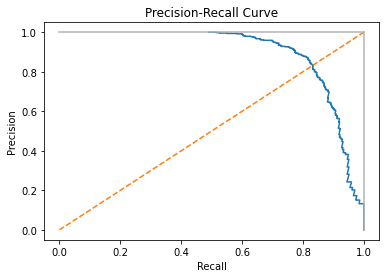

In [12]:
from sklearn.metrics import precision_recall_curve

# 진짜 양성 비율과 거짓 양성 비율을 계산합니다.
precision, recall, threshold = precision_recall_curve(target_test, target_probabilities)

# ROC 곡선을 그립니다.
plt.title("Precision-Recall Curve")
plt.plot(precision, recall)
plt.plot([0, 1], ls="--")
plt.plot([1, 1], c=".7"), plt.plot([1, 1], [1, 0], c=".7")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

정밀도-재현율 곡선에서는 오른쪽 맨 위에 가까울수록 좋은 모델입니다. 이 곡선의 아래 면적을 평균 정밀도라고 부르며 average_precision_score 함수를 사용해 계산할 수 있습니다.

In [13]:
from sklearn.metrics import average_precision_score

# 평균 정밀도를 계산합니다.
average_precision_score(target_test, target_probabilities)

0.8984128719848978

다음처럼 교차검증 함수의 scoring 매개변수에 ROCAUC와 평균 정밀도를 평가 지표로 지정할 수도 있습니다.

In [15]:
from sklearn.model_selection import cross_validate

cross_validate(logit, features, target, scoring=["roc_auc", "average_precision"])

{'fit_time': array([0.05485415, 0.05283737, 0.03082991, 0.02692866, 0.02692485]),
 'score_time': array([0.02306867, 0.01795125, 0.01196885, 0.01296735, 0.0139637 ]),
 'test_roc_auc': array([0.9007689, 0.918251 , 0.90882  , 0.915359 , 0.90261  ]),
 'test_average_precision': array([0.90028629, 0.90967443, 0.90296471, 0.91135611, 0.88797021])}

## 11.6 다중클래스 분류기 예측 평가하기
세 개 이상의 클래스를 예측하는 모델의 성능을 평가하고 싶습니다.

두 개 이상의 클래스를 다룰 수 있는 평가 지표로 교차검증을 수행합니다.

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

features, target = make_classification(n_samples = 10000,
                                       n_features = 3,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 3,
                                       random_state = 1)

logit = LogisticRegression()

cross_val_score(logit, features, target, scoring="accuracy")

array([0.841 , 0.829 , 0.8265, 0.8155, 0.82  ])

클래스가 균형 잡혀 있을 때 이진 클래스의 경우와 같이 정확도는 간단하고 해석이 용이한 평가 지표입니다. 정확도는 올바르게 예측한 수를 전체 샘플 수로 나눈 것이고 이진 분류에서처럼 다중 클래스에서도 잘 맞습니다. 그러나 불균형한 클래스에서는 다른 평가 지표를 사용하는 것이 낫습니다.

사이킷런에 포함된 지표 중 다수는 이진 분류기를 평가하는 용도입니다. 하지만 이런 지표를 클래스가 두 개 이상일 때로 확장할 수 있습니다. 정밀도, 재현율, $F_1$ 점수는 원래 이진 분류기를 위해 고안되었지만 훈련 데이터를 이진 클래스처럼 취급하는 방식으로 다중 클래스 환경에도 적용할 수 있습니다. 데이터에 하나의 클래스만 있는 것처럼 각 클래스에서 측정한 값을 수집하여 평균함으로써 전체 클래스에 대한 평가 점수를 얻을 수 있습니다.

In [2]:
# 마크로 평균 F1 점수를 사용하여 교차검증을 수행합니다.
cross_val_score(logit, features, target, scoring="f1_macro")

array([0.84061272, 0.82895312, 0.82625661, 0.81515121, 0.81992692])

이 코드에서 _macro는 클래스별 평가 점수를 평균하는 방법을 나타냅니다.
* macro: 각 클래스를 동등한 가중치로 클래스별 측정 점수를 평균합니다.
* weighted: 샘플 개수에 비례하여 각 클래스별 측정 점수를 평균합니다.
* micro: 클래스별로 TP, TN, FP, FN을 모두 더하여 계산합니다.

## 11.7 분류기 성능 시각화하기
테스트 데이터의 예측 클래스와 진짜 클래스를 바탕으로 모델의 품질을 시각적으로 비교하고 싶습니다.

오차 행렬(confusion matrix)을 사용해 예측 클래스와 진짜 클래스를 비교합니다.

C:\Users\dain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


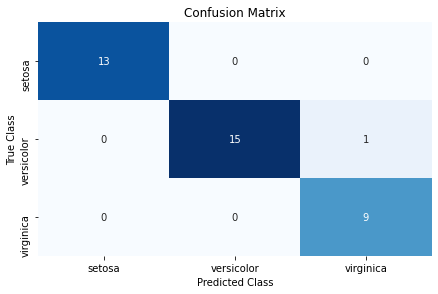

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

iris = datasets.load_iris()

features = iris.data

target = iris.target

# 클래스 이름의 리스트를 만듭니다.
class_names = iris.target_names

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1)

classifier = LogisticRegression()

# 모델을 훈련하고 예측 결과를 계산합니다.
target_predicted = classifier.fit(features_train, target_train).predict(features_test)

# 오차 행렬을 만듭니다.
matrix = confusion_matrix(target_test, target_predicted)

# 판다스 데이터프레임을 만듭니다.
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# 히트맵을 만듭니다.
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

오차 행렬은 분류기의 성능을 쉽고 효과적으로 보여주는 도구입니다. 오차 행렬의 핵심 장점 중 하나는 해석이 용이하다는 것입니다. 이 행렬의 열은 예측 클래스를 나타내고 행은 진짜 클래스를 나타냅니다(종종 히트맵으로 표현됩니다). 각 셀은 예측과 진짜의 가능한 조합 중 하나가 됩니다. 예를 들어 설명하면 이해하기 쉽습니다. 해결에서 왼쪽 맨 위의 셀은 Iris setosa(열)로 예측한 것 중에서 실제로 Iris setosa(행)인 샘플 개수입니다. 여기서는 모델이 모든 Iris setosa 꽃을 올바르게 예측했습니다. 그러나 이 모델은 Iris virginica를 잘 예측하지 못했습니다. 오른쪽 아래 셀은 9개의 샘플을 Iris virginica로 성공적으로 예측했지만 실제는 Iris versicolor인 꽃 6개를 virginica로 예측했습니다.

오차 행렬에 대해 세 가지 언급할 것이 있습니다. 첫째, 완벽한 모델은 대각선에만 값이 있고 나머지는 모두 0입니다. 나쁜 모델은 모든 셀에 고르게 샘플들이 퍼져 있을 것입니다. 둘째, 오차 행렬은 모델이 나쁘다는 것뿐만 아니라 어떻게 나쁜지도 알려줍니다. 즉 잘못 분류된 패턴을 확인할 수 있습니다. 예를 들어, 이 모델은 Iris virginica와 Iris setosa를 쉽게 구분하지만 Iris virginica와 Iris versicolor를 구분하는 데는 어려움을 겪고 있습니다. 마지막으로 오차 행렬은 다중 클래스 환경에도 잘 동작합니다.

사이킷런의 confusion_matrix 함수를 사용하여 오차 행렬을 계산할 수도 있습니다. 이 행렬의 행과 열은 해결에 나온 오차 행렬 그래프의 행과 열과 같습니다.

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target_test, target_predicted)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]], dtype=int64)

## 11.8 회귀 모델 평가하기
회귀 모델의 성능을 평가하고 싶습니다.

MSE를 사용합니다.

In [9]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   n_informative = 3,
                                   n_targets = 1,
                                   noise = 50,
                                   coef = False,
                                   random_state = 1)

ols = LinearRegression()

# 음의 MSE를 사용한 교차검증을 수행합니다.
cross_val_score(ols, features, target, scoring='neg_mean_squared_error')

array([-1974.65337976, -2004.54137625, -3935.19355723, -1060.04361386,
       -1598.74104702])

자주 사용하는 또 다른 회귀 지표는 결정계수 $R^2$입니다.

In [10]:
cross_val_score(ols, features, target, scoring='r2')

array([0.8622399 , 0.85838075, 0.74723548, 0.91354743, 0.84469331])

MSE는 가장 널리 사용하는 회귀 모델 평가 지표입니다. 오차 항을 제곱하면 여러 가지 수학적 장점이 있습니다. 하지만 전체 오차의 절댓갑시 같을 때도 작은 오차 보다 큰 오차를 나쁘다고 여깁니다. 예를 들면 A, B 두 모델과 샘플 두 개를 다음과 같이 가정해보죠.
* 모델 A의 오차는 0과 10입니다. 그러므로 MSE는 $0^2+10^2=100$입니다.
* 모델 B의 오차는 모두 5입니다. 그러므로 MSE는 $5^2+5^2=50$입니다.

두 모델은 전체 오차가 동일하지만 MSE는 모델 A가 모델 B보다 더 나쁘다고 판단합니다. 실제 이런 영향이 문제가 되는 경우가 드뭅니다. MSE는 평가 지표로 완벽하게 잘 작동합니다.

한 가지 중요한 점은 기본적으로 사이킷런의 scoring 매개변수값은 높은 값이 낮은 값보다 좋은 것이어야 합니다. MSE는 반대로 높은 값이 더 나쁜 모델을 의미합니다. 이런 이유 때문에 사이킷런의 neg_mean_squared_error를 사용하여 음의 MSE를 전달해야 합니다.

널리 사용하는 다른 회귀 평가 지표는 $R^2$입니다. 이 지표는 모델이 설명하는 타깃 벡터의 분산을 측정합니다. $R^2$값이 1.0에 가까울수록 더 좋은 모델입니다.

## 11.9 군집 모델 평가하기
데이터를 cluster로 모으기 위해서 비지도 학습 알고리즘을 사용했습니다. 이 모델이 얼마나 잘 동작했는지 알고 싶습니다.

clustering을 평가하는 한 가지 방법은 클러스터의 품질을 측정하는 silhouette coefficients입니다.

In [12]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

features, _ = make_blobs(n_samples = 1000,
                         n_features = 10,
                         centers = 2,
                         cluster_std = 0.5,
                         shuffle = True,
                         random_state = 1)

# k-평균을 사용하여 데이터를 클러스터링하고 클래스를 예측합니다.
model = KMeans(n_clusters=2, random_state=1).fit(features)

# 예측된 클래스
target_predicted = model.labels_

# 모델을 평가합니다. 
silhouette_score(features, target_predicted)

C:\Users\dain\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.8916265564072142

지도 학습 모델 평가는 타깃 벡터의 정답값과 예측값을 비교합니다. 군집 방법을 사용하는 대부분의 이유는 타깃 벡터가 없기 때문입니다. 하지만 여러 가지 군집 평가 지표는 타깃 벡터를 필요로 합니다. 타깃 벡터를 가지고 있을 때 군집 같은 비지도 학습 방법을 사용하면 불필요하게 스스로를 제약하는 셈입니다.

타깃 벡터가 없기 때문에 예측과 정답을 평가할 수 없지만 군집 자체의 특성을 평가할 수 있습니다. 클러스터 내의 샘플 간의 거리는 가깝고 클러스터 간 거리는 먼 것이 좋은 클러스터라고 직관적으로 생각할 수 있습니다. 실루엣 계수는 이 두 특성을 측정한 하나의 수치를 제공합니다. $i$번째 샘플의 실루엣 계수를 구하는 공식은 다음과 같습니다.
$$ s_i = \frac{b_i - a_i}{max(a_i,b_i)}$$

여기에서 $s_i$는 샘플 $i$의 실루엣 계수입니다. $a_i$는 샘플 $i$와 같은 클래스 안에 있는 모든 다른 샘플 사이의 평균 거리입니다. $b_i$는 샘플 $i$와 가장 가까운 다른 클러스터 안에 있는 샘플 사이의 평균 거리입니다. silhouette_score 함수의 반환값은 모든 샘플의 실루엣 계수를 평균한 값입니다. 실루엣 계수의 범위는 -1과 1 사이입니다. 1은 조밀하고 잘 구분되는 클러스터를 의미합니다.

## 11.10 사용자 정의 평가 지표 만들기
자신만의 지표를 사용하여 모델을 평가하고 싶습니다.

평가 방법을 함수로 만들고 사이킷런의 make_scorer 함수를 사용하여 scorer function으로 변환합니다.

In [2]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   random_state = 1)


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=1)

# 사용자 정의 지표를 만듭니다.
def custom_metric(target_test, target_predicted):
    # R^2 점수를 계산합니다.
    r2 = r2_score(target_test, target_predicted)
    # R^2 점수를 반환합니다.
    return r2

# 높은 점수가 좋은 것을 나타내는 스코어 함수를 만듭니다.
score = make_scorer(custom_metric, greater_is_better=True)

# 리지(ridge) 회귀 모델을 만듭니다.
classifier = Ridge()

# 리지 회귀 모델을 훈련합니다.
model = classifier.fit(features_train, target_train)

# 사용자 정의 스코어 함수를 적용합니다.
score(model, features_test, target_test)

0.9997906102882058

사이킷런이 모델 성능을 평가하는 함수를 많이 제공하지만 종종 자신만의 측정 지표를 정의해야 할 경우가 있습니다. 사이킷런의  make_scorer 함수를 사용하면 간단합니다. 먼저 두 개의 매개변수를 가진 함수를 정의합니다. 이 함수는 정답 타깃 벡터와 예측값을 받고 어떤 점수를 출력합니다. 그다음 make_scorer 함수를 사용해 스코어 객체를 만듭니다. 높은 점수와 낮은 점수 중에 (greater_is_better 매개변수를 사용해) 바람직한 것을 지정합니다.

해결에 있는 사용자 정의 지표는 간단한 예입니다. 단순히 $R^2$ 점수를 계산하는 내장 함수를 감쌌습니다. 실전 상황에서는 custom_metric 함수 대신 원하는 어떤 측정 함수로 바꾸게 됩니다. 이 경우에는 $R^2$을 계산하는 사용자 정의 함수가 제대로 작동하는지 사이킷런의 r2_score 내장 함수의 결과를 비교해볼 수 있습니다.

In [3]:
# 예측
target_predicted = model.predict(features_test)

# R^2 점수를 계산합니다.
r2_score(target_test, target_predicted)

0.9997906102882058

## 11.11 훈련 세트 크기에 따른 영향을 시각화하기
어떤 측정 지표(정확도, $F_1$ 등)로 훈련 세트에 있는 샘플 개수에 따른 영향을 평가하고 싶습니다.

학습 곡선(learning curve)을 그립니다.

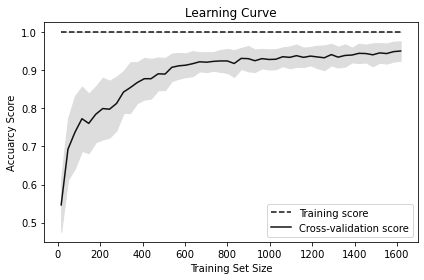

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

digits = load_digits()

features, target = digits.data, digits.target

# 다양한 훈련 세트 크기에서 교차검증 훈련 점수와 테스트 점수를 계산합니다.
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), # 분류기
                                                        features, # 특성 행렬
                                                        target, # 타깃 벡터
                                                        cv = 10, # 폴드 수
                                                        scoring = 'accuracy', # 성능 지표
                                                        n_jobs = -1, # 모든 코어 사용
                                                        train_sizes = np.linspace(0.01, 1.0, 50)) # 50개의 훈련 세트 크기

# 훈련 세트 점수의 평균과 표준편차를 계산합니다.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
                                                        
# 테스트 점수의 평균과 표준편차를 계산합니다.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
                                                        
# 그래프를 그립니다.
plt.plot(train_sizes, train_mean, '--', color = '#111111', label = "Training score")
plt.plot(train_sizes, test_mean, color = "#111111", label = "Cross-validation score")
                                                        
# 표준편차 영역을 그립니다.
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#DDDDDD")

# 그래프를 출력합니다.
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuarcy Score")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

학습 곡선은 훈련 세트의 샘플 수가 증가함에 따라 훈련 세트와 교차검증의 성능(예를 들면, 정확도나 재현율)을 시각화합니다. 더 많은 훈련 데이터를 모아서 학습 알고리즘에 도움될지 결정하는 데 널리 사용됩니다.

해결에서 훈련 세트 샘플의 1%에서 100%까지 50개의 크기에서 random forest 분류기의 정확도를 그래프로 그렸습니다. 모델의 교차검증 정확도가 증가하면 추가적인 샘플이 도움이 된다는 것을 의미합니다,

## 11.12 평가 지표 리포트 만들기
분류기 성능을 간단하게 요약하고 싶습니다.

사이킷런의 classification_report를 사용합니다.

In [2]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

iris = datasets.load_iris()

features = iris.data

target = iris.target

class_names = iris.target_names

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1)

classifier = LogisticRegression(max_iter=1000)

model = classifier.fit(features_train, target_train)
target_predicted = model.predict(features_test)

# 분류 리포트를 만듭니다.
print(classification_report(target_test, target_predicted, target_names = class_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



classification_report는 첫 번째 블럭에서 각 클래스를 양성 클래스로 가정했을 때 점수를 보여줍니다. 두 번째 블럭은 micro, macro, weighted 평균값을 출력합니다. 사이킷런 0.21 버전에서 labels 매개변수가 지정되지 않거나 labels 매개변수로 전달된 클래스 레이블이 타깃값에 포함되어 있다면 micro 평균과 같은 의미인 정확도를 출력합니다.

labels에 존재하지 않는 네 번째 레이블을 추가하여 분류 리포트를 다시 실행해보겠습니다. 네 번째 레이블에 예측 샘플이 없어 경고가 발생하지만 micro avg 통계를 볼 수 있습니다.

In [3]:
# 분류 리포트를 만듭니다.
print(classification_report(target_test,
                            target_predicted,
                            labels = [0,1,2,3]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9
           3       0.00      0.00      0.00         0

   micro avg       0.97      0.97      0.97        38
   macro avg       0.72      0.73      0.73        38
weighted avg       0.98      0.97      0.97        38



C:\Users\dain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dain\anaconda3\lib\site-packages\sklearn\metrics\_classif

## 11.13 하이퍼파라미터 값의 영향을 시각화하기
일부 하이퍼파라미터 값을 변경할 때 모델의 성능 변화를 알고 싶습니다.

validation curve를 그립니다.

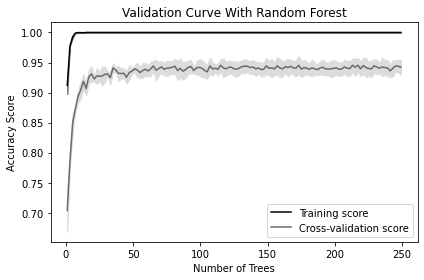

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

digits = load_digits()
features, target = digits.data, digits.target

# 파라미터 값의 범위를 만듭니다.
param_range = np.arange(1, 250, 2)

# 파라미터 값의 범위를 사용하여 훈련 세트와 테스트 세트의 정확도를 계산합니다.
train_scores, test_scores = validation_curve(RandomForestClassifier(), # 분류기
                                              features, # 특성 행렬
                                              target, # 타깃 벡터
                                              param_name = "n_estimators", # 조사할 하이퍼파라미터
                                              param_range = param_range, # 하이퍼파라미터 값의 범위
                                              cv = 3, # 폴드 수
                                              scoring = "accuracy", # 성능 지표
                                              n_jobs = -1)  # 모든 코어 사용
                                              

# 훈련 세트 점수의 평균과 표준편차를 계산합니다.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# 테스트 세트 점수의 평균과 표준편차를 계산합니다.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 훈련 세트와 테스트 세트의 평균 정확도 점수를 그래프로 그립니다.
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# 훈련 세트와 테스트 세트의 정확도에 대한 표준편차를 그래프로 그립니다.
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# 그래프를 출력합니다.
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

RandomForest Classifier의 hyperparameter는 ensemble을 할 tree의 개수입니다. 많은 경우 하이퍼파라미터 값은 모델 선택 과정을 통해 선택합니다. 하지만 때로는 하이퍼파라미터 값의 변화에 따라 모델 성능의 변화를 시각화하는 것이 도움이 됩니다. 해결에서 트리 개수가 증가할 때 랜덤 포레스트 분류기의 훈련 세트 정확도와 교차검증 정확도의 변화를 그래프로 나타냈습니다. 트리 개수가 적을 때는 훈련 세트의 점수와 교차검증 점수가 모두 낮아 모델이 underfit 되었습니다. 트리 개수를 250개까지 늘리면 두 정확도 모두 변화없이 평탄해집니다. 이 문제를 위해 대규모 랜덤 포레스트 모델을 훈련할 가치가 없다는 것을 의미합니다.

사이킷런에서 validation_curve 함수로 검증 곡선을 계산할 수 있습니다. 이 함수는 세 개의 중요한 파라미터가 있습니다.
* param_name은 바꿀 하이퍼파라미터의 이름입니다.
* param_range는 사용할 하이퍼파라미터 범위입니다.
* scoring은 모델을 평가하는 데 사용할 지표입니다.